# **Importando bibliotecas**

In [80]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# instalar openpyxl para leitura dos arquivos excel (https://stackoverflow.com/a/56992903)

# **Importando dados**
Construí paths relativos independentes do sistema operacional para facilitar o uso por outros usuários.

In [3]:
# Lendo arquivos excel

# Obtendo o path deste notebook
current_dir = os.getcwd()

# Construindo o path para os arquivos excel
itens_path = os.path.join(current_dir, 'dados', 'itens.xlsx')
pedido_path = os.path.join(current_dir, 'dados', 'pedido.xlsx')
itens_pedido_path = os.path.join(current_dir, 'dados', 'itens_pedido.xlsx')

# Importando arquivos excel como dataframes
df_itens = pd.read_excel(itens_path)
df_pedido = pd.read_excel(pedido_path)
df_itens_pedido = pd.read_excel(itens_pedido_path)

## Preparação dos dataframes
1. Renomear colunas de df_itens: 'ID_ITEM' e 'PRECO_ITEM'
2. Dropar colunas inúteis de df_pedido e df_itens_pedido: 'Unnamed: 0'
3. Adicionar coluna 'PRECO_ITEM' na tabela 'df_itens_pedido': utilize a tabela df_itens
4. Adicionar coluna 'PRECO_TOTAL_ITEM' na tabela df_itens_pedido: ela vai multiplicar PRECO_ITEM por QUANTIDADE
5. Adicionar coluna 'DATA' na tabela df_itens_pedido: utilizar a tabela df_pedido
6. PARA DESCOBRIR O PREÇO TOTAL POR PEDIDO:
    1. Agrupar a tabela df_itens_pedido por ID_PEDIDO, gerando uma nova tabela com as seguintes colunas:
        - ID_PEDIDO
        - DATA
        - PRECO_PEDIDO: é a soma das linhas em PRECO_TOTAL_ITEM para cada grupo de ID_PEDIDO
    2. Essa nova tabela pode se chamar df_pedidos


In [ ]:
# renomear colunas de df_itens
df_itens = df_itens.rename(columns={
    'Unnamed: 0': 'ID_ITEM',
    0: 'PRECO_ITEM'
})

In [ ]:
# descartar colunas Unnamed de df_pedido e df_itens_pedido
df_pedido = df_pedido.drop(columns='Unnamed: 0')
df_itens_pedido = df_itens_pedido.drop(columns='Unnamed: 0')

In [ ]:
# adicionar 'PRECO_ITEM' na tabela 'df_itens_pedido' utilizando a tabela 'df_itens'
df_itens_pedido = df_itens_pedido.merge(df_itens, on='ID_ITEM')

In [ ]:
# adicionar 'PRECO_TOTAL_ITEM' em 'df_itens_pedido'
df_itens_pedido['PRECO_TOTAL_ITEM'] = df_itens_pedido['QUANTIDADE'] * df_itens_pedido['PRECO_ITEM']
df_itens_pedido.head()

In [18]:
# adicionar coluna 'DATA' em 'df_itens_pedido' utilizando 'df_pedido'
df_itens_pedido = df_itens_pedido.merge(df_pedido, on='ID_PEDIDO')
df_itens_pedido = df_itens_pedido.drop(columns='VALOR_TOTAL')
# df_itens_pedido.head()

,ID_PEDIDO,ID_ITEM,QUANTIDADE,PRECO_ITEM,PRECO_TOTAL_ITEM,DATA
0,120210601,item C,4,20,80,2021-06-01
1,220210601,item A,3,10,30,2021-06-01
2,320210604,item C,1,20,20,2021-06-04
3,420210604,item B,4,15,60,2021-06-04
4,420210604,item C,2,20,40,2021-06-04


In [26]:
# verificando se cada pedido ocorre apenas em uma única data
unique_dates = df_pedido.groupby(by='ID_PEDIDO')['DATA'].nunique()

pedidos_varias_datas = unique_dates[unique_dates > 1]

if not pedidos_varias_datas.empty:
    print("Pedidos com múltiplas datas:")
    print(pedidos_varias_datas)
else:
    print("Todos os pedidos têm apenas datas diferentes")

# criar nova tabela agrupando todosos dados por pedido, exibindo o valor total por pedido = soma de 'PRECO_TOTAL_ITEM' por ID_PEDIDO
df_pedidos = df_itens_pedido.groupby(by='ID_PEDIDO', as_index=False).agg({
    'PRECO_TOTAL_ITEM':'sum',
    'DATA': 'first'
})
df_pedidos = df_pedidos.rename(columns={'PRECO_TOTAL_ITEM':'VALOR_PEDIDO'})
df_pedidos.head()

,ID_PEDIDO,VALOR_PEDIDO,DATA
0,120210601,80,2021-06-01
1,220210601,30,2021-06-01
2,320210604,20,2021-06-04
3,420210604,100,2021-06-04
4,520210604,30,2021-06-04


Agora temos duas tabelas importantes no projeto:

- *df_itens_pedido*, com informações detalhadas de itens por pedido, com preço do item, preço total, data
    - Esta tabela é a que será mais usada, pois o exercício pede uma previsão de demanda de itens.
- *df_pedidos*, com informações consolidadas dos pedidos feitos, com o valor total do pedido (que pode ter vários itens) e a data do pedido.
    - Esta tabela pode ser útil para previsão de faturamento da rede, pois consolida os dados de vendas.

# **Análise Exploratória (EDA)**
Dos requisitos do projeto:

*Realizar uma análise descritiva para entender o comportamento das vendas, identificar padrões sazonais e outras características relevantes.*

- Nomes de colunas
- Dimensões
- Tipos de dados
- Estatística descritiva: 
    - Separar em dados categóricos e numéricos
    - Analisar a distribuição dos dados
    - Analisar a correlação dos dados (matriz de correlação): atenção porque nem todas as variáveis podem ser correlacionadas


In [41]:
# informações gerais da tabela: nomes de colunas, tamanho, tipos de dados
print('\nInformações gerais do dataset:')
df_itens_pedido.info()

# quantidade de valores únicos
print('\nQuantidade de valores únicos:')
df_itens_pedido.nunique()


Informações gerais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID_PEDIDO         295 non-null    int64 
 1   ID_ITEM           295 non-null    object
 2   QUANTIDADE        295 non-null    int64 
 3   PRECO_ITEM        295 non-null    int64 
 4   PRECO_TOTAL_ITEM  295 non-null    int64 
 5   DATA              295 non-null    object
dtypes: int64(4), object(2)
memory usage: 14.0+ KB

Quantidade de valores únicos:


ID_PEDIDO           181
ID_ITEM               4
QUANTIDADE            5
PRECO_ITEM            4
PRECO_TOTAL_ITEM     13
DATA                 81
dtype: int64

In [35]:
# estatísticas descritivas da tabela
print('Estatísticas descritivas:')
df_itens_pedido.drop(columns='ID_PEDIDO').describe().round(2) # desconsidera coluna 'ID_PEDIDO'

Estatísticas descritivas:


,QUANTIDADE,PRECO_ITEM,PRECO_TOTAL_ITEM
count,295.00,295.00,295.00
mean,3.03,17.90,54.10
std,1.42,5.62,31.12
min,1.00,10.00,10.00
25%,2.00,15.00,30.00
50%,3.00,20.00,50.00
75%,4.00,25.00,75.00
max,5.00,25.00,125.00


### Gráficos Descritivos


Histogramas:


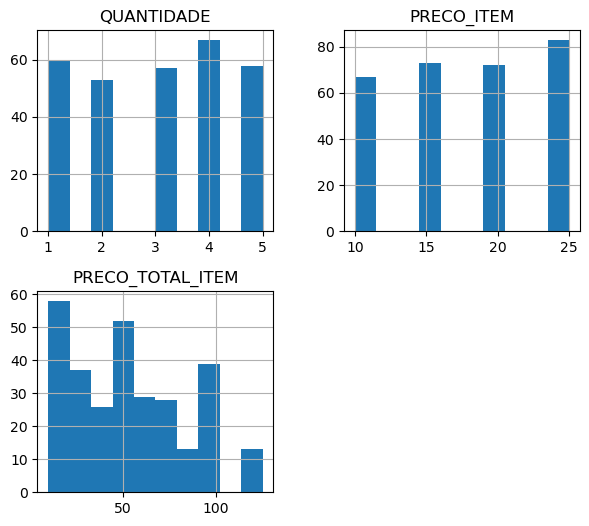

In [50]:
# histogramas
print('\nHistogramas:')
df_itens_pedido.drop(columns='ID_PEDIDO').hist(figsize=(7,6))
plt.show()

## Perguntas de Negócio

*OBS: agrupar os dados por DATA, sendo que cada data representa uma linha, e cada linha tem: DATA, QTD_A, QTD_B, QTD_C, QTD_D. Essa tabela permite acompanhar a quantidade de cada item vendido no tempo, facilitando a análise de demanda.*

1. Qual a tendência de demanda de cada item? E a demanda generalizada (por todos os itens)? Plotar gráficos.
2. Qual o mês de maior demanda e de menor demanda para cada item?
3. Qual o dia da semana de maior demanda e de menor demanda para cada item?
4. Existe algum padrão de demanda: mensal, trimestral, anual?
5. Qual item tem a maior demanda? E a menor?
6. Como o preço influencia a demanda? Existe correlação entre o preço dos itens e a quantidade vendida?
7. Características dos pedidos: qual o pedido médio (em termos de quantidade de itens e preço)?

(*essas perguntas vão nos ajudar a estimar quando cada item é mais demandado, permitindo trabalhar o estoque com maior precisão. Além disso, saberemos se o preço impacta na demanda e quais ítens são mais demandados*)

### 6. Como o preço influencia a demanda?

In [76]:
# Agrupando os dados por preço do item.
# A intenção é verificar a relação entre preço do item x quantidade vendida (demanda)
df_precos = df_itens_pedido.groupby(by='PRECO_ITEM')['QUANTIDADE'].sum().reset_index()
df_precos.head()

,PRECO_ITEM,QUANTIDADE
0,10,211
1,15,217
2,20,216
3,25,251


In [89]:
# Correlação (linear) entre preço do item e quantidade pedida
corr_coef, _ = pearsonr(df_precos['PRECO_ITEM'], df_precos['QUANTIDADE']) # o uso de ', _' indica que descartamos outros valores retornados pela função. Queremos apenas o primeiro valor.
print(f"Coeficiente de Correlação (Pearson) entre PREÇO DO ITEM e QUANTIDADE PEDIDA: {corr_coef:.4f}")

Coeficiente de Correlação (Pearson) entre PREÇO DO ITEM e QUANTIDADE PEDIDA: 0.8370


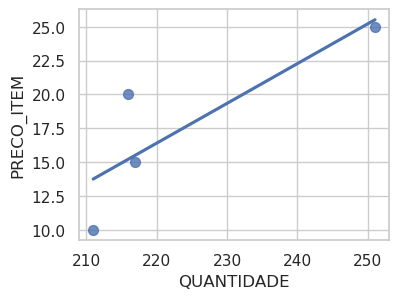

In [92]:
# Scatterplot para avaliar a linearidade entre preço dos itens e quantidade
sns.set_theme(style="whitegrid")
plt.figure(figsize=(4, 3))
ax = sns.regplot(x='QUANTIDADE', y='PRECO_ITEM', data=df_precos, ci=None, scatter_kws={'s': 50})

Como se vê no scatter plot, os dados não são lineares. Há um outlier ali nos itens com preço de 25. É preciso tratar esse outlier antes de prosseguirmos na análise da relação entre essas 2 variáveis. A correlação precisará ser recalculada também.

# Featuring Engineering
- Preparar e transformar os dados para o treinamento dos modelos de machine learning
    - Standardization
    - Rescaling
    - Encoding
    - Features Selection (seleção de atributos): se o número de atributos for grande, podemos utilizar um modelo para selecioná-los, como o Boruta.
- Tratamento de dados (nomes de colunas, linhas vazias, duplicadas)

(*ver https://towardsdatascience.com/lets-do-feature-engineering-5731efc3d7fe*)

# Modelagem
1. Identificar o tipo de problema: previsão (forecasting)
2. Identificar tipos de modelos de machine learning adequados. Para previsão são estes:
    - Modelos de Séries Temporais (ARIMA, SARIMA)
    - Modelos de Regressão (linear, random forest, gradient boosting (XGBoost))
3. Escolher modelo baseline: o mais simples possível (média)
4. Separar dados em treino e teste
5. Coletar performance para cada modelo escolhido: avaliar métricas adequadas p/os modelos escolhidos
    - MAE
    - MAPE
    - RMSE
    - Forecast Bias
    - R-squared
6. Escolhido o modelo, fazer o *fine tunning* dele (cuidado com overfitting)
7. Coletar a performance do modelo otimizado (métricas e gráfico de previsão x resultado real) e salvar o modelo para não precisar treiná-lo novamente.